<a href="https://colab.research.google.com/github/rrfsantos/Projeto-Redes-Neurais-OCT-Images/blob/main/TCC/StratifiedKFold/OCT2017_dataset_Xception_classifier_StratifiedKFold_total.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Métodos automatizados para detectar e classificar doenças humanas a partir de imagens médicas, utilizando aprendizado profundo 

Projeto de conclusão do curso BI-MASTER na PUC-RJ

Aluna: Renata Regina da Fonseca Santos

Orientadora: Professora Evelyn Conceição


## Objetivo

Utilização de modelos de inteligência artificial pré-treinados como alternativa para predição de diagnóstico em novos exames expostos aos modelos. Itens do trabalho:

*   Análise exploratória dos dados
*   Tratamento dos dados para uso na rede neural
*   Investigar as melhores opções de configuração para o caso proposto
*   Avaliação do modelo utilizando validação cruzada




## Descrição dos dados

O dataset é composto por imagens de Tomografia de Coerência Óptica da Retina (OCT), técnica de imagem usada para capturar seções transversais de alta resolução das retinas. É organizado em 3 diretórios (train, test, val). Cada um desses diretórios contém subdiretórios para cada categoria de imagem (NORMAL, CNV, DME,DRUSEN). São 84,495 imagens (JPEG) e 4 categorias:

*   CNV (choroidal neovascularization) -  Processo patológico que consiste da formação de novos vasos sanguíneos na COROIDE.

*   DME (diabetic macular edema) - Ao longo do tempo, níveis glicêmicos altos podem levar a complicações vasculares em vários tecidos e órgãos, como no coração, sistema nervoso, rins, membros inferiores (pernas e pés) e inclusive nos olhos.

*   DRUSEN - pequenos depósitos amarelos ou brancos na retina do olho ou na cabeça do nervo óptico. A presença de drusas é um dos sinais precoces mais comuns de degeneração macular relacionada à idade.

*   NORMAL



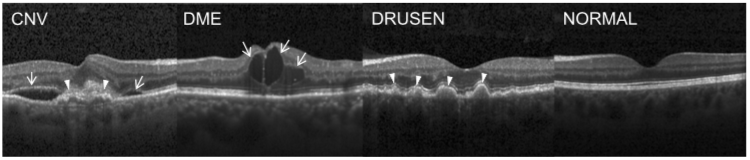

Labeled Optical Coherence Tomography (OCT) Images for Classification - Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2





### Importação das Bibliotecas

Este trabalho baseou-se na API Keras para a construção da rede neural para inferência dos diagnósticos.

https://keras.io

In [ ]:
### Keras ###
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

### sklearn ###
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix

### Demais Bibliotecas ###
import pandas as pd
import numpy as np
from numpy import unique
import shutil
import random
from imutils import paths
import os
import cv2
import glob
import matplotlib.pyplot as plt
from collections import Counter
import statistics
import warnings

warnings.filterwarnings("ignore")
np.random.seed(0)

### Download da base do Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"renatarfsantos","key":"1401c3f022bf52f986b9ee0943db5879"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/kermany2018 -p /content/

100% 10.8G/10.8G [02:47<00:00, 99.4MB/s]
100% 10.8G/10.8G [02:47<00:00, 69.4MB/s]


In [ ]:
!unzip -o -q /content/kermany2018.zip

### Montar o Google Drive para salvar os resultados do treino e da avaliação do modelo

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Análise Exploratória

### Separação da base em treino, teste e validação

As imagens nos diretórios train / val / test originais estavam repetidas, foi preciso fazer nova separação

In [ ]:
dataset_path = '/content/OCT2017 /train'
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [ ]:
# Criar novos diretórios train / val / test (One time use)

test_ratio = 0.10

for cls in classes:

  os.makedirs(dataset_path +'/train/' + cls)
  os.makedirs(dataset_path +'/test/' + cls)
  os.makedirs(dataset_path +'/val/' + cls)

  # Creating partitions of the data after shuffeling
  src = dataset_path + '/' + cls # Folder to copy images from

  allFileNames = os.listdir(src)
  np.random.shuffle(allFileNames)
  train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - test_ratio))])


  train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]


  print('Total images '+ cls + ':', len(allFileNames))
  print('Training '+ cls + ':', len(train_FileNames))
  print('Testing '+ cls + ':', len(test_FileNames))
  
  # Copy-pasting images
  
  for name in train_FileNames:
    shutil.copy(name, dataset_path +'/train/' + cls)

  for name in test_FileNames:
    shutil.copy(name, dataset_path +'/test/' + cls)                                              

Total images CNV: 37205
Training CNV: 33484
Testing CNV: 3721
Total images DME: 11348
Training DME: 10213
Testing DME: 1135
Total images DRUSEN: 8616
Training DRUSEN: 7754
Testing DRUSEN: 862
Total images NORMAL: 26315
Training NORMAL: 23683
Testing NORMAL: 2632


### Visualização de 4 imagens de cada classe do dataset

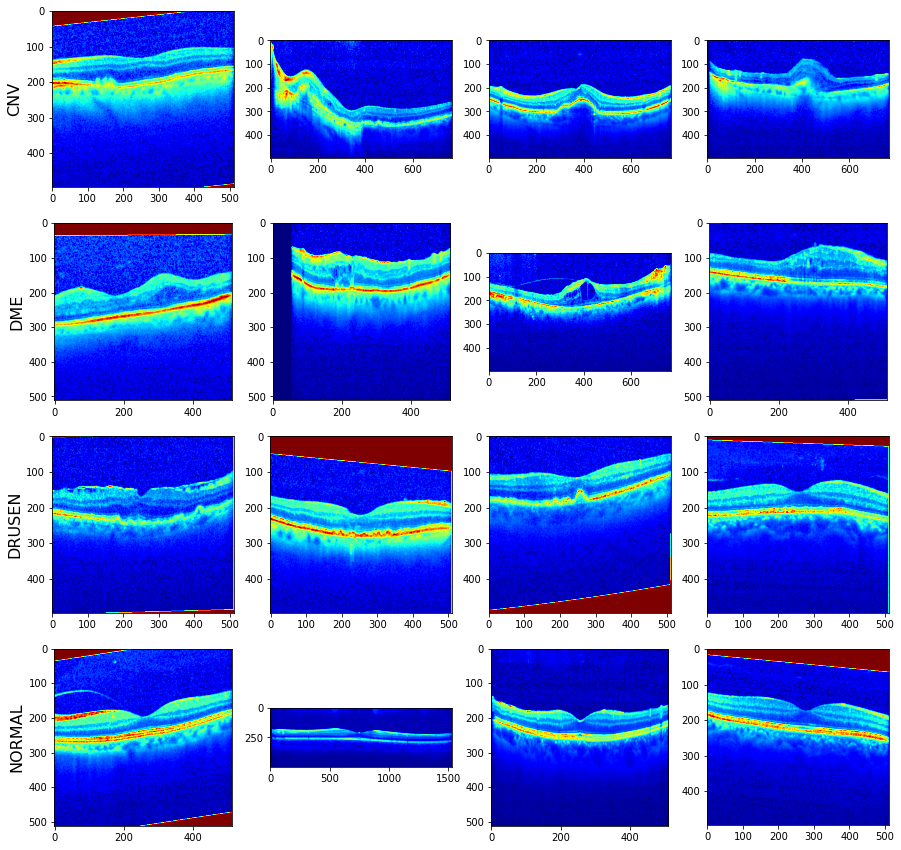

In [ ]:
cnv_examples = glob.glob(dataset_path + '/CNV/*')
dme_examples = glob.glob(dataset_path + '/DME/*')
drusen_examples = glob.glob(dataset_path + '/DRUSEN/*')
normal_examples = glob.glob(dataset_path + '/NORMAL/*')

examples = cnv_examples[:4] + dme_examples[:4] + drusen_examples[:4] + normal_examples[:4]

fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4
for i in range(columns*rows):
    img = plt.imread(examples[i])
    ax = fig.add_subplot(rows, columns, i+1)
    if i%4==0:
        plt.ylabel(classes[int(i/4)], fontsize=16)
    plt.imshow(img, cmap='jet')
plt.show()      

### Verificação do balanceamento da base

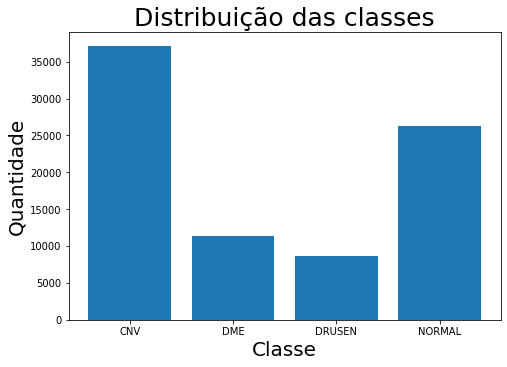

In [ ]:
total_cnv_samples = len(glob.glob(dataset_path + '/CNV/*'))
total_dme_samples = len(glob.glob(dataset_path + '/DME/*'))
total_drusen_samples = len(glob.glob(dataset_path + '/DRUSEN/*'))
total_normal_samples = len(glob.glob(dataset_path + '/NORMAL/*'))

sample_distribution = [total_cnv_samples, total_dme_samples, total_drusen_samples, total_normal_samples]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes, sample_distribution)
plt.xlabel("Classe", fontsize=20)
plt.ylabel("Quantidade", fontsize=20)
#fig.set_size_inches( 25, 8)
plt.title("Distribuição das classes", fontsize=25) 
plt.show();

## Pré-Processamento - Tratamento dos dados para uso na rede neural

### Organizar nome de arquivos e classes em variáveis X e Y

In [ ]:
num_classes = len(classes)

X=[]
y=[]

train_FileNames = glob.glob(dataset_path + '/train/*/*')

for i in range(num_classes):
  for j in range(len(train_FileNames)):  
    if classes[i] in (os.path.basename(train_FileNames[j])):
      X.append(train_FileNames[j])
      y.append(classes[i])

#train_data = pd.DataFrame({'filename':X, 'label':y})

X=np.asarray(X)
y=np.asarray(y)

## Construção da rede neural Xception pré-treinada utilizando a base de dados "imageNet"

https://keras.io/api/applications/xception/

https://arxiv.org/abs/1610.02357

In [ ]:
trainDataDir = '/content/OCT2017 /train/train'
testDataDir = '/content/OCT2017 /train/test'

In [ ]:
init_lr = 0.045
epochs = 40
batchSize = 64

### Carregar a rede Xception

83697664/83683744 [==============================] - 1s 0us/step


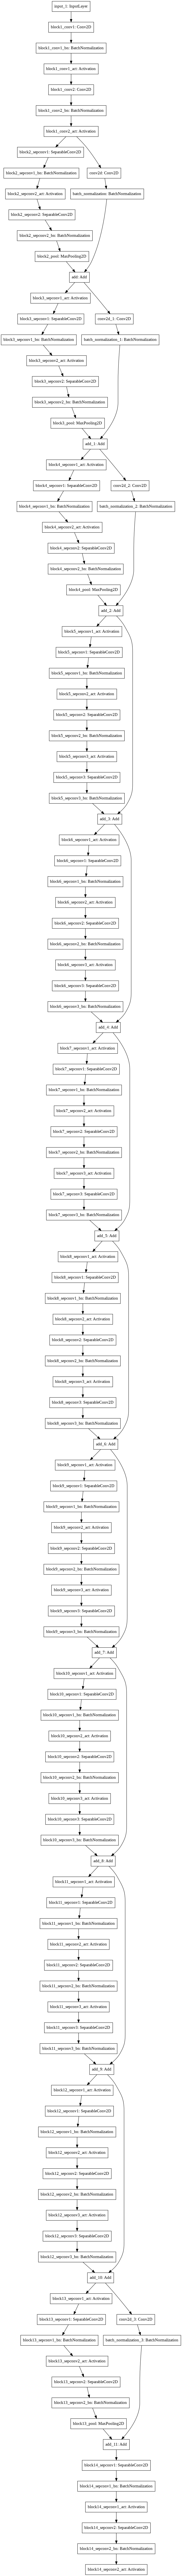

In [ ]:
# Carregar a rede Xception certificando-se de que as camadas principais Full Connected (FC) sejam deixadas de fora

baseModel = Xception(include_top=False, weights='imagenet', input_shape=(299,299,3))

# Congela todas as camadas do modelo para que * não * sejam atualizadas durante o primeiro processo de treinamento
for layer in baseModel.layers:
    layer.trainable = False

plot_model(baseModel)

### Função auxiliar para criar a Rede Neural

In [ ]:
def get_model():

  # Construir as camadas Full Connected (FC) "top" do modelo, que substituirão a base da Xception
  headModel = baseModel.output
  headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dense(num_classes, activation="softmax")(headModel)
    
  # Construir o modelo CNN
  model = Model(inputs=baseModel.input, outputs=headModel)

  # Compilar o modelo
  opt = SGD(lr=init_lr, decay=init_lr / epochs, momentum=0.9)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])
  
  return model

### Criar instâncias de treino e validação da classe ImageDataGenerator

In [ ]:
trainDataGen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=9,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest'
                                  )


validationDataGen = ImageDataGenerator(rescale=1./255)


### Função auxiliar para avaliação do modelo

### Stratified K-Fold

##### Variação de KFold que retorna amostras estratificadas. As amostras são feitas preservando-se o percentual de cada classe.

In [ ]:
foldNum = 0
save_dir = '/content/drive/My Drive/TCC/'

skf = StratifiedKFold(n_splits=3, shuffle=True)
skf.get_n_splits(X, y)

for train_index, val_index in skf.split(X,y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    foldNum+=1

    for cls in classes: 
        os.makedirs(dataset_path + '/kfold/train/' + cls)
        os.makedirs(dataset_path + '/kfold/val/' + cls)
        for file in X_train:
            if cls in (os.path.basename(file)):
                shutil.copy(file, dataset_path +'/kfold/train/'+ cls + '/')
        for file in X_val:
            if cls in (os.path.basename(file)):
                shutil.copy(file, dataset_path +'/kfold/val/'+ cls + '/')
                    
    # Data Augmentation - Aumenta a quantidade de dados, adicionando cópias ligeiramente modificadas de dados já existentes
    # ou dados sintéticos recém-criados a partir de dados existentes
    
    kfoldTrainDir = '/content/OCT2017 /train/kfold/train/'
    trainGenerator = trainDataGen.flow_from_directory(kfoldTrainDir,
                                                      target_size=(299, 299),   ## O tamanho padrão da imagem de entrada para a rede neural Xception é 299 x 299
                                                      batch_size=batchSize,
                                                      class_mode='categorical',
                                                      shuffle = True
                                                      )
    kfoldValDir = '/content/OCT2017 /train/kfold/val/'
    validationGenerator = validationDataGen.flow_from_directory(kfoldValDir,
                                                                target_size=(299, 299),   ## O tamanho padrão da imagem de entrada para a rede neural Xception é 299 x 299
                                                                batch_size=batchSize,
                                                                class_mode='categorical',
                                                                )

    # Callbacks
    mc = ModelCheckpoint(filepath = save_dir + 'model' + str(foldNum) + '.h5', monitor='categorical_accuracy', save_best_only=True, mode='max')
    es = EarlyStopping(patience=10, monitor="val_loss", mode='auto', restore_best_weights=True)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
    hl = CSVLogger(save_dir + 'history_kfolds.csv', separator=";", append=True)

    # Balanceamento do Dataset
    weights = class_weight.compute_class_weight('balanced', np.unique(trainGenerator.classes), trainGenerator.classes)
    class_weights = {i: weights[i] for i in range(len(weights))}
    
    # Treinamento
    print('\n','------------ Treinamento para fold',foldNum, '------------','\n')

    model = get_model()
    stepsTraining = trainGenerator.samples // batchSize
    stepsValidation = validationGenerator.samples // batchSize

    history = model.fit(trainGenerator,
        steps_per_epoch = stepsTraining,
        epochs=epochs,
        validation_data = validationGenerator,
        validation_steps = stepsValidation,
        class_weight = class_weights,
        batch_size=batchSize,
        callbacks=[mc,es,rlr,hl]
        )
    
    # Reiniciar o ambiente de execução
    shutil.rmtree(kfoldTrainDir)
    shutil.rmtree(kfoldValDir)
    tf.keras.backend.clear_session()


Found 50089 images belonging to 4 classes.
Found 25045 images belonging to 4 classes.

 ------------ Treinamento para fold 1 ------------ 

Epoch 1/40
782/782 [==============================] - 1198s 2s/step - loss: 2.5360 - categorical_accuracy: 0.6854 - val_loss: 1.9809 - val_categorical_accuracy: 0.6996
Epoch 2/40
782/782 [==============================] - 1198s 2s/step - loss: 1.4124 - categorical_accuracy: 0.7502 - val_loss: 1.2335 - val_categorical_accuracy: 0.7618
Epoch 3/40
782/782 [==============================] - 1195s 2s/step - loss: 1.0489 - categorical_accuracy: 0.7731 - val_loss: 0.7804 - val_categorical_accuracy: 0.8125
Epoch 4/40
782/782 [==============================] - 1195s 2s/step - loss: 0.8897 - categorical_accuracy: 0.7835 - val_loss: 0.5484 - val_categorical_accuracy: 0.8557
Epoch 5/40
782/782 [==============================] - 1176s 2s/step - loss: 0.7865 - categorical_accuracy: 0.7930 - val_loss: 0.4945 - val_categorical_accuracy: 0.8666
Epoch 6/40
782/782 [

## Avaliação do Modelo

### Histórico de treinamento do Modelo em cada Fold

In [ ]:
result_kfolds = pd.DataFrame.from_dict(results, orient='index')
result_kfolds.head(foldNum)

NameError: ignored

### Avaliação dos modelos gerados utilizando a base de teste

In [ ]:
test_images_path = glob.glob(testDataDir + '/*/*.jpeg')
x_test = []
y_test = []
for i in range(len(test_images_path)):
    img = cv2.imread(test_images_path[i])
    img = cv2.resize(img, (299,299))
    img = np.array(img/255.0)
    x_test.append(img)
    if 'CNV' in test_images_path[i]:
        y_test.append(0)
    elif 'DME' in test_images_path[i]:
        y_test.append(1)
    elif 'DRUSEN' in test_images_path[i]:
        y_test.append(2)
    elif 'NORMAL' in test_images_path[i]:
        y_test.append(3)
y_test = np.array(y_test)
x_test = np.array(x_test)
print(x_test.shape, y_test.shape)

In [ ]:
reports = {}
for i in range(foldNum):
    print('\n', '------------ Resultados para fold',foldNum, '------------','\n')

    model.load_weights('/content/OCT2017 /model_' + str(i) + '.h5') # carrega os pesos de uma das redes

    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis=1)

    labels = ('CNV', 'DME', 'DRUSEN', 'NORMAL')

    y_actu = pd.Series(y_test, name='Actual')
    y_pred = pd.Series(y_pred, name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred)

    df_conf_norm = df_confusion / df_confusion.sum(axis=1)

    # Matriz de Confusão
    plt.figure(figsize=(15, 15))
    plt.matshow(df_confusion, cmap=plt.get_cmap('Blues'), fignum=1)  # imshow
    #plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels,fontsize=16)
    plt.yticks(tick_marks, labels, fontsize=16)
    thresh = 0.6

    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(i, j, (df_confusion[i][j]),
                    horizontalalignment='center', fontsize = 16)

    plt.tight_layout()
    plt.title('Matriz de Confusão', fontsize=24)
    plt.ylabel(df_confusion.index.name, fontsize=18)
    plt.xlabel(df_confusion.columns.name,fontsize=18)
    plt.show()

    # Matriz de Confusão Normalizada
    plt.figure(figsize=(15, 15))
    plt.matshow(df_confusion, cmap=plt.get_cmap('Blues'), fignum=1)  # imshow
    #plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels,fontsize=16)
    plt.yticks(tick_marks, labels, fontsize=16)
    thresh = 0.6

    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(i, j, "{:0.2f}%".format(df_conf_norm[i][j] * 100),
                    horizontalalignment='center', fontsize = 16)

    plt.tight_layout()
    plt.title('Matriz de Confusão Normalizada', fontsize=24)
    plt.ylabel(df_confusion.index.name, fontsize=18)
    plt.xlabel(df_confusion.columns.name,fontsize=18)
    plt.show()

    # Classification Report
    reports[i] = (classification_report(y_actu, y_pred, target_names = labels, output_dict=True))
    print(classification_report(y_actu, y_pred, target_names = labels)

In [ ]:
df_class_report_kfolds = pd.DataFrame.from_dict(reports, orient='index')

In [ ]:
df_class_report_kfolds.to_csv(save_dir + 'classification_report_kfolds.csv',encoding='utf-8', sep=';')